In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import mne
import scipy.io as spio
from mne.io import RawArray
from mne import create_info
import matplotlib.pyplot as plt

## Downloading dataset

In [3]:
!wget --no-check-certificate http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip

--2023-01-26 17:22:41--  http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Resolving bbci.de (bbci.de)... 130.149.80.149
Connecting to bbci.de (bbci.de)|130.149.80.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip [following]
--2023-01-26 17:22:42--  https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Connecting to bbci.de (bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252211988 (241M) [application/zip]
Saving to: ‘BCICIV_1_mat.zip’

BCICIV_1_mat.zip    100%[===================>] 240.53M  28.5MB/s    in 9.0s    

2023-01-26 17:22:51 (26.6 MB/s) - ‘BCICIV_1_mat.zip’ saved [252211988/252211988]



In [4]:
!unzip BCICIV_1_mat.zip

Archive:  BCICIV_1_mat.zip
  inflating: BCICIV_calib_ds1a.mat   
  inflating: BCICIV_calib_ds1b.mat   
  inflating: BCICIV_calib_ds1c.mat   
  inflating: BCICIV_calib_ds1d.mat   
  inflating: BCICIV_calib_ds1e.mat   
  inflating: BCICIV_calib_ds1f.mat   
  inflating: BCICIV_calib_ds1g.mat   
  inflating: BCICIV_eval_ds1a.mat    
  inflating: BCICIV_eval_ds1b.mat    
  inflating: BCICIV_eval_ds1c.mat    
  inflating: BCICIV_eval_ds1d.mat    
  inflating: BCICIV_eval_ds1e.mat    
  inflating: BCICIV_eval_ds1f.mat    
  inflating: BCICIV_eval_ds1g.mat    


In [5]:
# to check the directory files
!ls -la

total 594548
drwxr-xr-x 1 root root      4096 Jan 26 17:23 .
drwxr-xr-x 1 root root      4096 Jan 26 17:19 ..
-rw-r--r-- 1 root root 252211988 Aug  3  2009 BCICIV_1_mat.zip
-rw-rw---- 1 root root  22496680 Jul  7  2008 BCICIV_calib_ds1a.mat
-rw-rw---- 1 root root  22496688 Jul  7  2008 BCICIV_calib_ds1b.mat
-rw-rw---- 1 root root  22491376 Jul  7  2008 BCICIV_calib_ds1c.mat
-rw-rw---- 1 root root  22482408 Jul  7  2008 BCICIV_calib_ds1d.mat
-rw-rw---- 1 root root  22465416 Jul  7  2008 BCICIV_calib_ds1e.mat
-rw-rw---- 1 root root  22498328 Jul  7  2008 BCICIV_calib_ds1f.mat
-rw-rw---- 1 root root  22497632 Jul  7  2008 BCICIV_calib_ds1g.mat
-rw-rw---- 1 root root  28391048 Jul  7  2008 BCICIV_eval_ds1a.mat
-rw-rw---- 1 root root  29147672 Jul  7  2008 BCICIV_eval_ds1b.mat
-rw-rw---- 1 root root  27542160 Jul  7  2008 BCICIV_eval_ds1c.mat
-rw-rw---- 1 root root  28926184 Jul  7  2008 BCICIV_eval_ds1d.mat
-rw-rw---- 1 root root  28142312 Jul  7  2008 BCICIV_eval_ds1e.mat
-rw-rw---- 1 roo

## Dataset and performed task explained

- Visual cues of two classes: left hand and right hand

- 2 runs of calibration with labels and cues information **(train set)**

- 4 runs of evaluation: no labels provided **(test set)**

To begin we focus on:
- 1 run for calibration/training and 
- 1 run for evaluation/testing





## Data loading

In [6]:
curr_dir = './'
train_data = spio.loadmat(f"{curr_dir}BCICIV_calib_ds1a.mat")
print(train_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])


In [7]:
test_data = spio.loadmat(f"{curr_dir}BCICIV_eval_ds1a.mat")
print(test_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'cnt', 'nfo'])


In [8]:
eeg = train_data['cnt']

print("cnt type: ", eeg.dtype)
print("cnt shape: ", eeg.shape)

cnt type:  int16
cnt shape:  (190594, 59)


In [9]:
nfo = train_data['nfo']
print("nfo shape: ", nfo.shape)

# A matlab struct is here rapresented as a 1x1 ndarray! 
# It seems very different from what we get in matlab, but if we see what's 
# in nfo.dtype we find out theres something similar to the matlab struct fields
print("nfo.dtype: ", nfo.dtype)

# We can call each field as if it was a dict, and the values of this dict are
# always 1x1 arrays: that's why we extract dict[<key>][0,0]
fs = int(nfo['fs'])
print('Sampling Frequency: ',fs)
classes = nfo['classes'][0,0]
clab = nfo['clab'][0,0]

nfo shape:  (1, 1)
nfo.dtype:  [('fs', 'O'), ('classes', 'O'), ('clab', 'O'), ('xpos', 'O'), ('ypos', 'O')]
Sampling Frequency:  100


In [10]:
chs = [c[0] for c in clab[0,:]]
n_channels = len(chs)
n_channels

59

In [11]:
train_rec = RawArray(eeg.T/1e7, create_info(chs, fs, ch_types='eeg'))

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


## Cue positions and labels extraction

We have 200 labeled trials.

- pos: vector of positions in time of the cue in the EEG signals given in unit sample, length #cues

- y: vector of target classes (-1 for class one or 1 for class two), length #cues

In [12]:
marker = train_data['mrk']
pos = marker['pos'][0,0][0]
y = marker['y'][0,0][0]

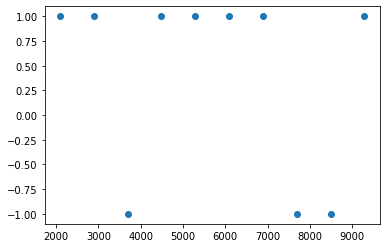

In [13]:
plt.plot(pos[0:10],y[0:10],'o')

In [14]:
# example
print(f'The first cue at {pos[0]} is labeled {y[0]}')

The first cue at 2091 is labeled 1


In [15]:
len_rec = train_rec.n_times

In [16]:
# MNE works with absolute values of labels so -1 and +1 would result in only one kind of event
# that's why we add 2 and obtain 1 and 3 as label values
y = y + 2
n_samples = len(y)

# Pre-processing
This dataset comes already filtered between 0.05 Hz and 1000 Hz, powerline frequencies already removed, then downsampled at 100 Hz see for details https://www.bbci.de/competition/iv/desc_1.html.

**NOTE**: the same pre-processing applied to the training data must be applied to the test data

In [17]:
eeg_test = test_data['cnt']

print("cnt type: ", eeg_test.dtype)
print("cnt shape: ", eeg_test.shape)

cnt type:  int16
cnt shape:  (240558, 59)


In [18]:
nfo_test = test_data['nfo']
print("nfo shape: ", nfo_test.shape)

# A matlab struct is here rapresented as a 1x1 ndarray! 
# It seems very different from what we get in matlab, but if we see what's 
# in nfo.dtype we find out theres something similar to the matlab struct fields
print("nfo_test.dtype: ", nfo_test.dtype)

# We can call each field as if it was a dict, and the values of this dict are
# always 1x1 arrays: that's why we extract dict[<key>][0,0]
fs_test = int(nfo_test['fs'])
print('Sampling Frequency: ',fs_test)
classes_test = nfo_test['classes'][0,0]
clab_test = nfo_test['clab'][0,0]

nfo shape:  (1, 1)
nfo_test.dtype:  [('fs', 'O'), ('classes', 'O'), ('clab', 'O'), ('xpos', 'O'), ('ypos', 'O')]
Sampling Frequency:  100


In [19]:
chs_test = [c[0] for c in clab_test[0,:]]
n_channels_test = len(chs_test)
n_channels_test

59

In [ ]:
test_rec = RawArray(eeg_test.T/1e7, create_info_test(chs_test, fs_test, ch_types_test='eeg'))

## Filtering

Using matplotlib as 2D backend.


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


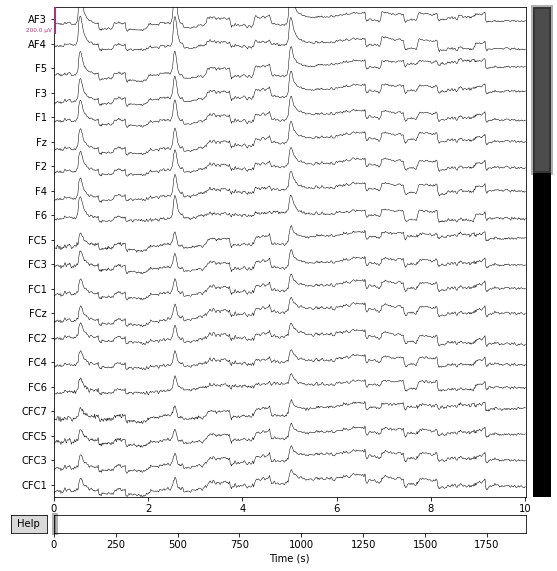

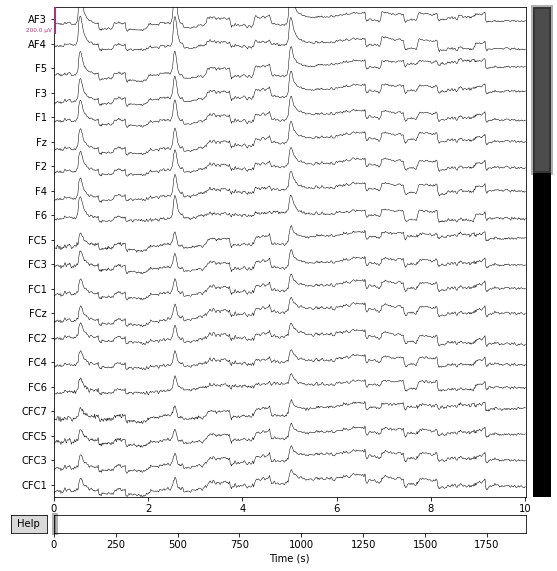

In [20]:
train_rec.plot(block=True, clipping=None, scalings=100e-6)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.9s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


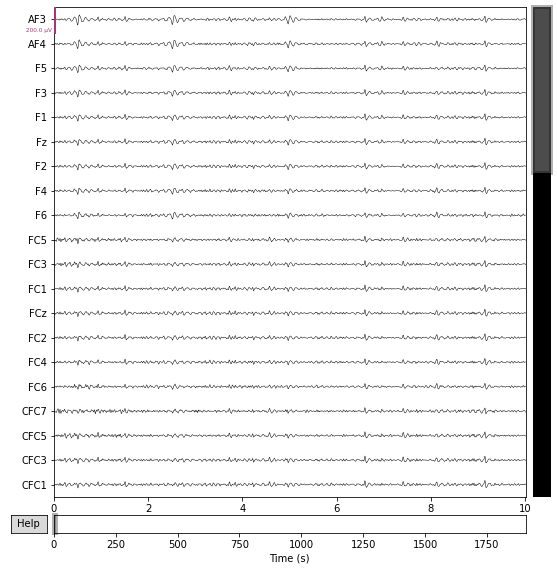

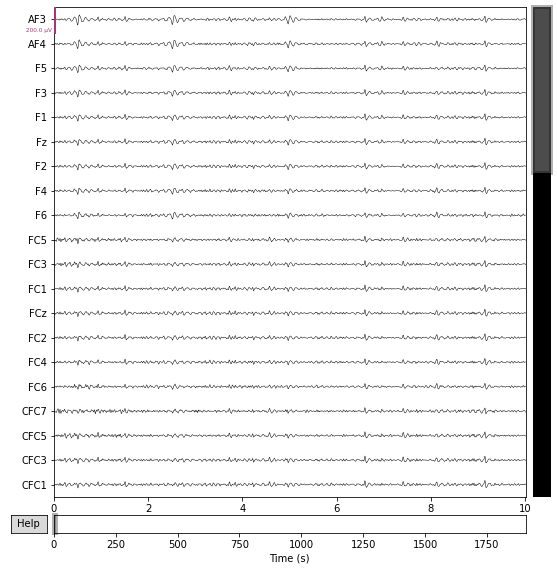

In [21]:
temp = train_rec.copy() # the method filters the signal in-place, so this time I 
                      # want to preserve the orignial signal and filter just a 
                      # temporary copy of it


temp.filter(8,30) # easy huh?!
temp.plot(block=True, clipping=None, scalings=100e-6)

# Clearly digging into MNE documentation and digital filters theory, you can 
# discover that many different filtering methods can be used, different orders 
# can be chosen, all of this to tune the processing to your specific necessities.
# Arguments can be passed to the .filter() method to alter the default settings. 

## Artifact removal 
(if you want)

## Epoching
How long was the subject instructed to practice MI?

# Feature extraction
MI is an oscillatory phenomenon...

# Classification with Scikit Learn
Remember to keep some labeled trials for testing...